# SME0823 Modelos de Regressão e Aprendizado Supervisionado II

# Decomposição Viés–Variância (Regressão, perda quadrática)


por **Cibele Russo**

**ICMC/USP - São Carlos SP**




Este notebook ilustra empiricamente a decomposição
$$
\mathbb{E}[(y-\widehat{g}(\mathbf{x}))^2] = \text{Viés}^2 + \text{Var} + \sigma^2,
$$
usando modelos polinomiais de diferentes graus para aproximar uma função verdadeira $ r(x)=\sin(2\pi x) $ sob erros Normais.

**Procedimento**
1. Gera vários conjuntos de treino a partir de $ r(x) $ com erros $ \mathcal{N}(0,\sigma^2) $;
2. Ajusta modelos polinomiais (graus configuráveis);
3. Estima, em um grid de $x\in[0,1]$, o **Viés²**, a **Variância**, o **Variância do Erro** $\sigma^2$;
4. Compara **EQM teórico** $(\text{Viés}^2 + \text{Var} + \sigma^2)$ e **EQM empírico**;
5. Gera gráficos e uma tabela resumo.


In [15]:
# Instalar dependências (caso necessário, descomente para ambientes sem scikit-learn)
# %pip install -q scikit-learn pandas matplotlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error

# Para gráficos mais nítidos em notebooks
%config InlineBackend.figure_format = 'retina'


In [16]:
# -------------------------
# Parâmetros
# -------------------------
rng = np.random.default_rng(42)
noise_sigma = 0.3         # desvio-padrão do erro (σ)
n_points = 30             # tamanho de cada conjunto de treino
n_trials = 200            # número de reamostragens
degrees = [1, 3, 5, 9]    # complexidade dos modelos (grau do polinômio)

# Domínio onde vamos avaliar as funções
X_grid = np.linspace(0, 1, 200).reshape(-1, 1)

# Verdadeira função r(x) (ajuste aqui se desejar)
def r(x):
    return np.sin(2 * np.pi * x)

y_true_grid = r(X_grid)


In [17]:

# -------------------------
# Simulação e ajuste
# -------------------------
results = []  # para armazenar métricas por grau
all_preds_by_degree = {}  # para guardar predições por ensaio e grau no grid

for d in degrees:
    preds_trials = []           # predições no grid para cada reamostragem
    mse_emp_trials = []         # EQM empírico no grid (proxy do risco esperado)

    for t in range(n_trials):
        # Gera dados de treino
        X = rng.uniform(0, 1, size=(n_points, 1))
        eps = rng.normal(0, noise_sigma, size=(n_points, 1))
        y = r(X) + eps

        # Ajusta modelo polinomial de grau d
        model = make_pipeline(PolynomialFeatures(d, include_bias=False), LinearRegression())
        model.fit(X, y.ravel())

        # Predições no grid
        y_hat_grid = model.predict(X_grid).reshape(-1, 1)
        preds_trials.append(y_hat_grid)

        # EQM empírico no grid com erro (proxy do risco esperado no domínio)
        eps_grid = rng.normal(0, noise_sigma, size=(X_grid.shape[0], 1))
        y_obs_grid = y_true_grid + eps_grid
        mse_emp = mean_squared_error(y_obs_grid, y_hat_grid)
        mse_emp_trials.append(mse_emp)

    # Empilha predições [n_trials, n_grid, 1]
    preds_trials = np.stack(preds_trials, axis=0)  # shape: (n_trials, n_grid, 1)

    # Média das predições no grid (E[\hat g(x)])
    mean_pred = preds_trials.mean(axis=0)  # shape: (n_grid, 1)

    # Viés^2 no grid: (E[\hat g(x)] - r(x))^2
    bias2_grid = (mean_pred - y_true_grid) ** 2

    # Variância no grid: Var(\hat g(x)) ao longo das reamostragens
    var_grid = preds_trials.var(axis=0)  # variância ao longo do eixo dos trials

    # Agrega média no domínio
    bias2 = float(bias2_grid.mean())
    variance = float(var_grid.mean())
    noise = float(noise_sigma**2)
    mse_theory = bias2 + variance + noise
    mse_empirical = float(np.mean(mse_emp_trials))

    results.append({
        "grau": d,
        "Vies2": bias2,
        "Variancia": variance,
        "Variância do erro (sigma^2)": noise,
        "EQM_teorico = Vies2 + Variancia + Variância do erro": mse_theory,
        "EQM_empirico (aprox.)": mse_empirical
    })

    # Armazena para gráficos
    all_preds_by_degree[d] = {
        "mean_pred": mean_pred,
        "preds_trials": preds_trials
    }

# Tabela de resultados
df = pd.DataFrame(results).sort_values("grau").reset_index(drop=True)
df


,grau,Vies2,Variancia,Variância do erro (sigma^2),EQM_teorico = Vies2 + Variancia + Variância do erro,EQM_empirico (aprox.)
0,1,0.199832,0.022641,0.09,0.312474,0.313533
1,3,0.005028,0.019294,0.09,0.114322,0.115207
2,5,0.000260,0.086897,0.09,0.177157,0.178933
3,9,0.000818,3.751180,0.09,3.841999,3.846404


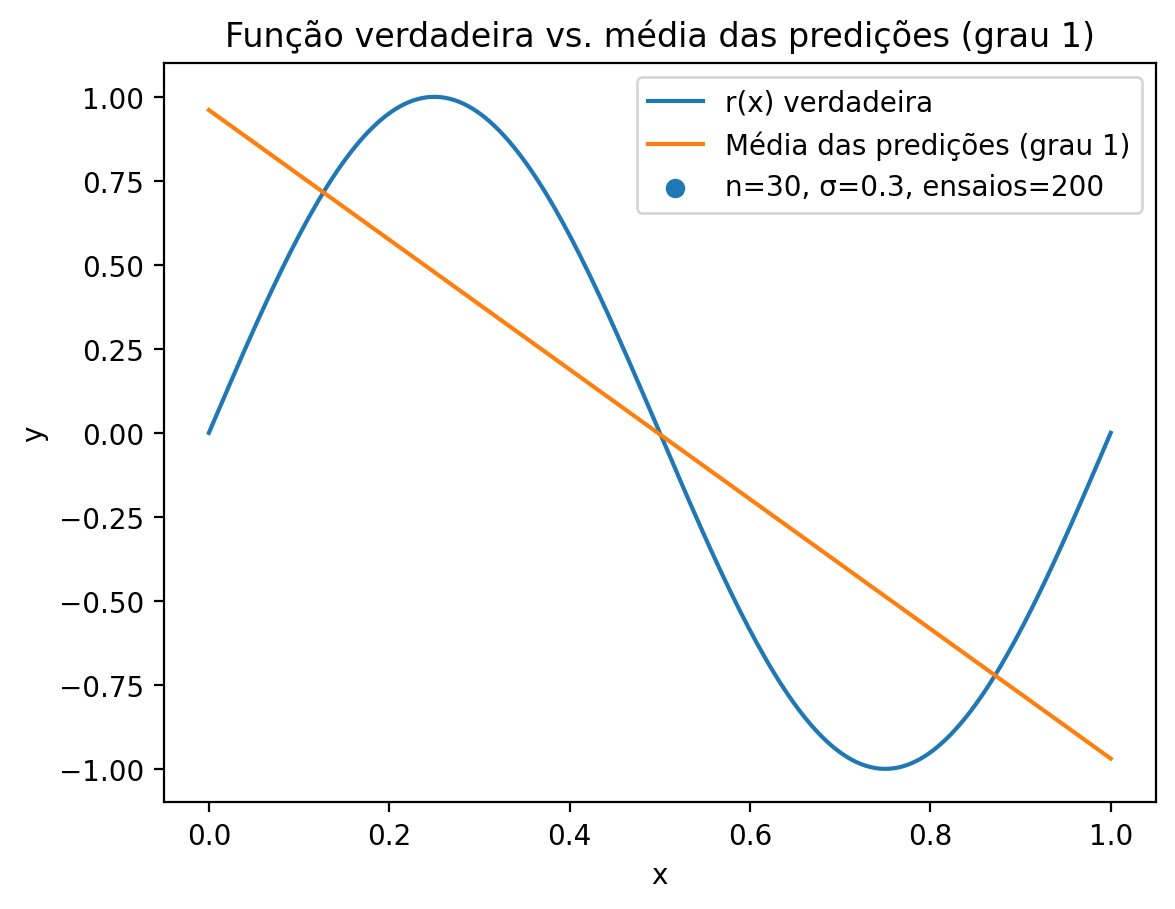

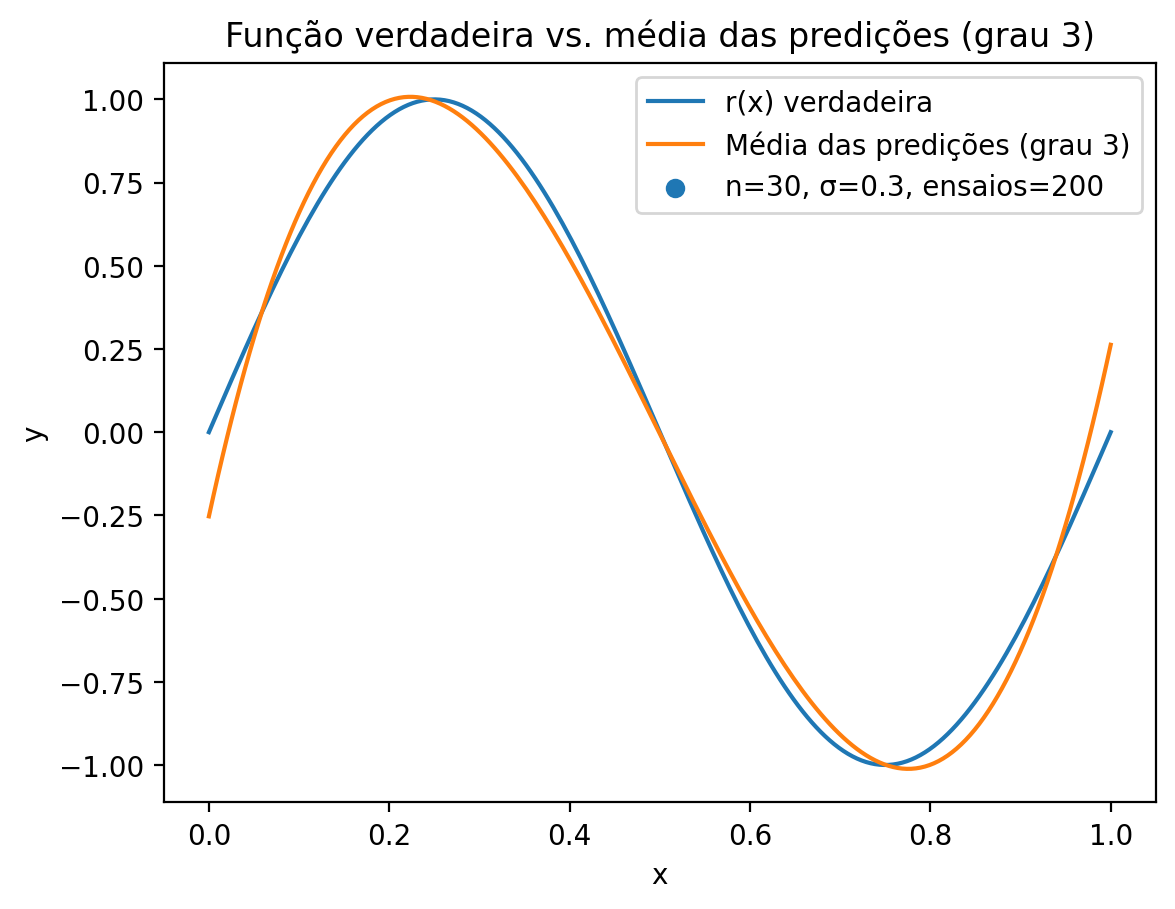

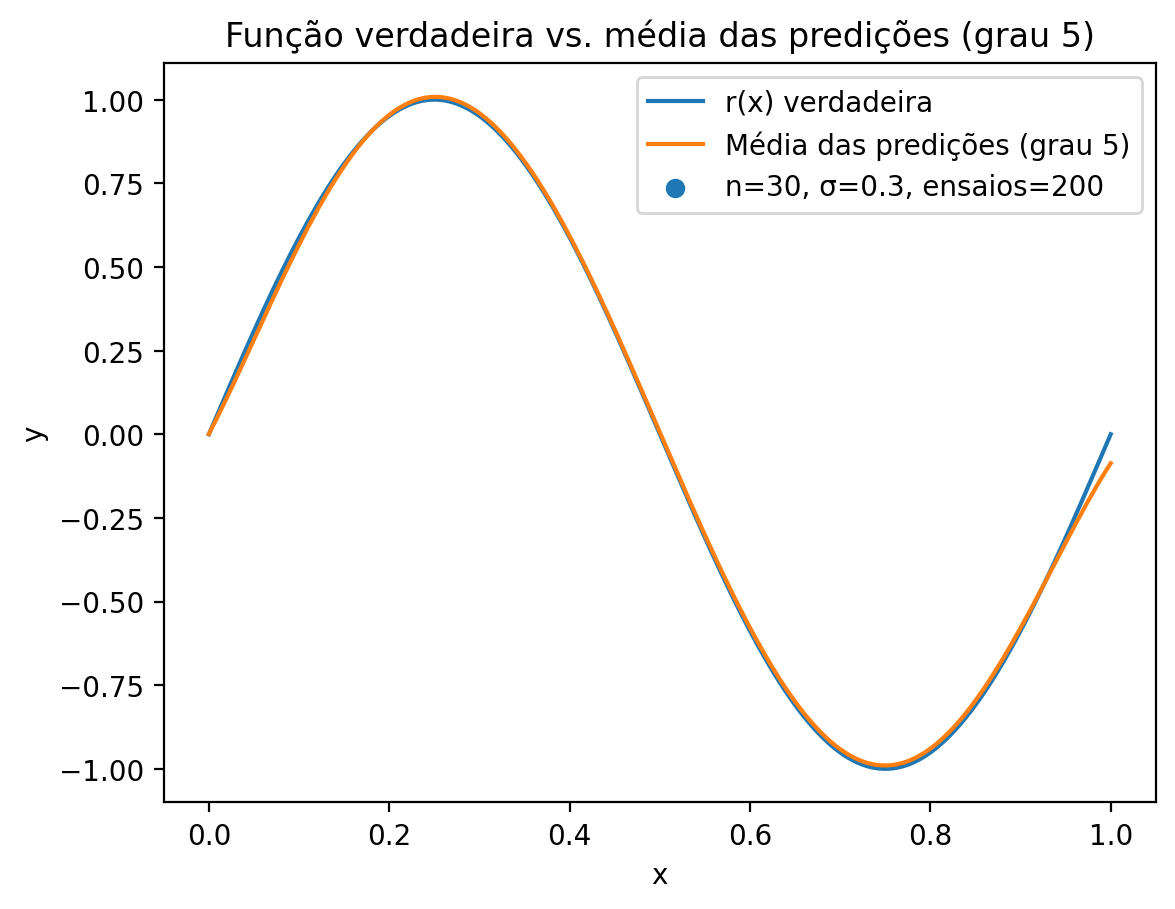

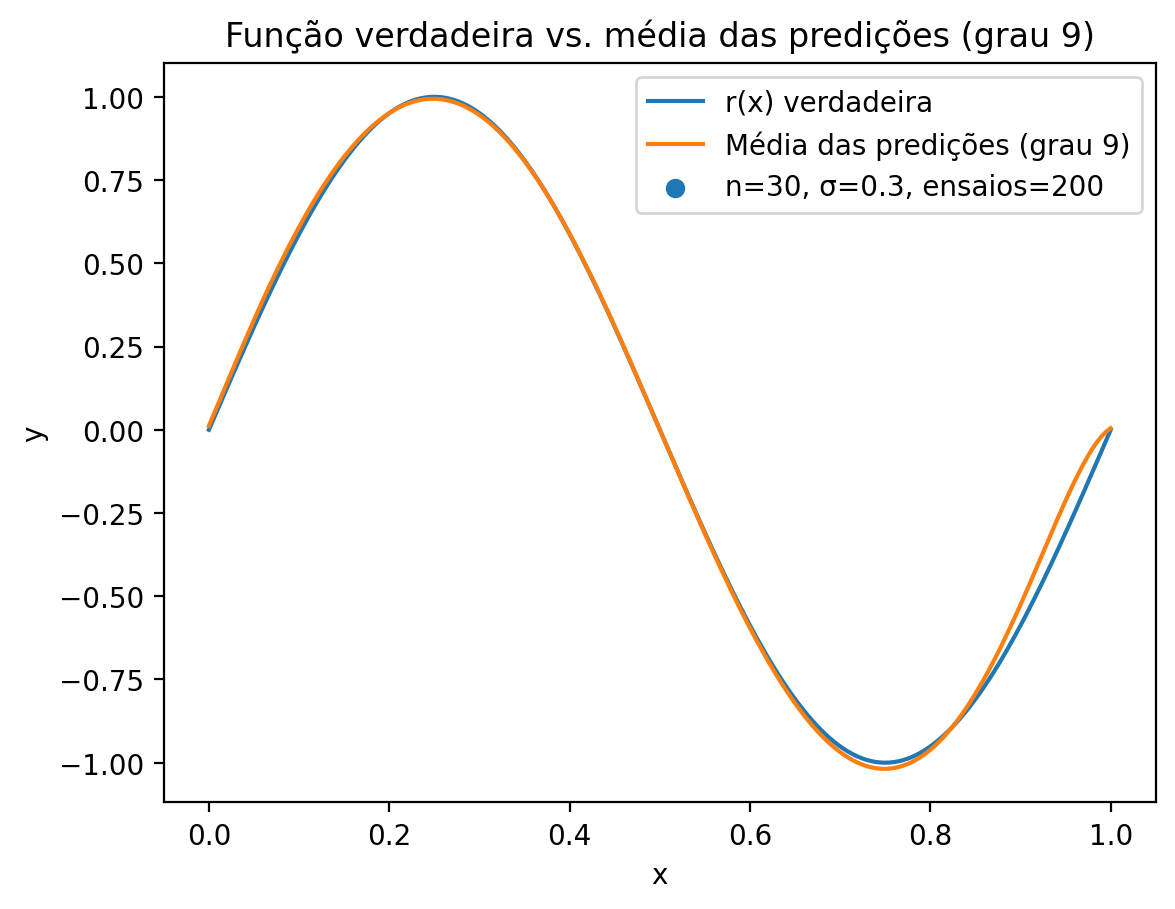

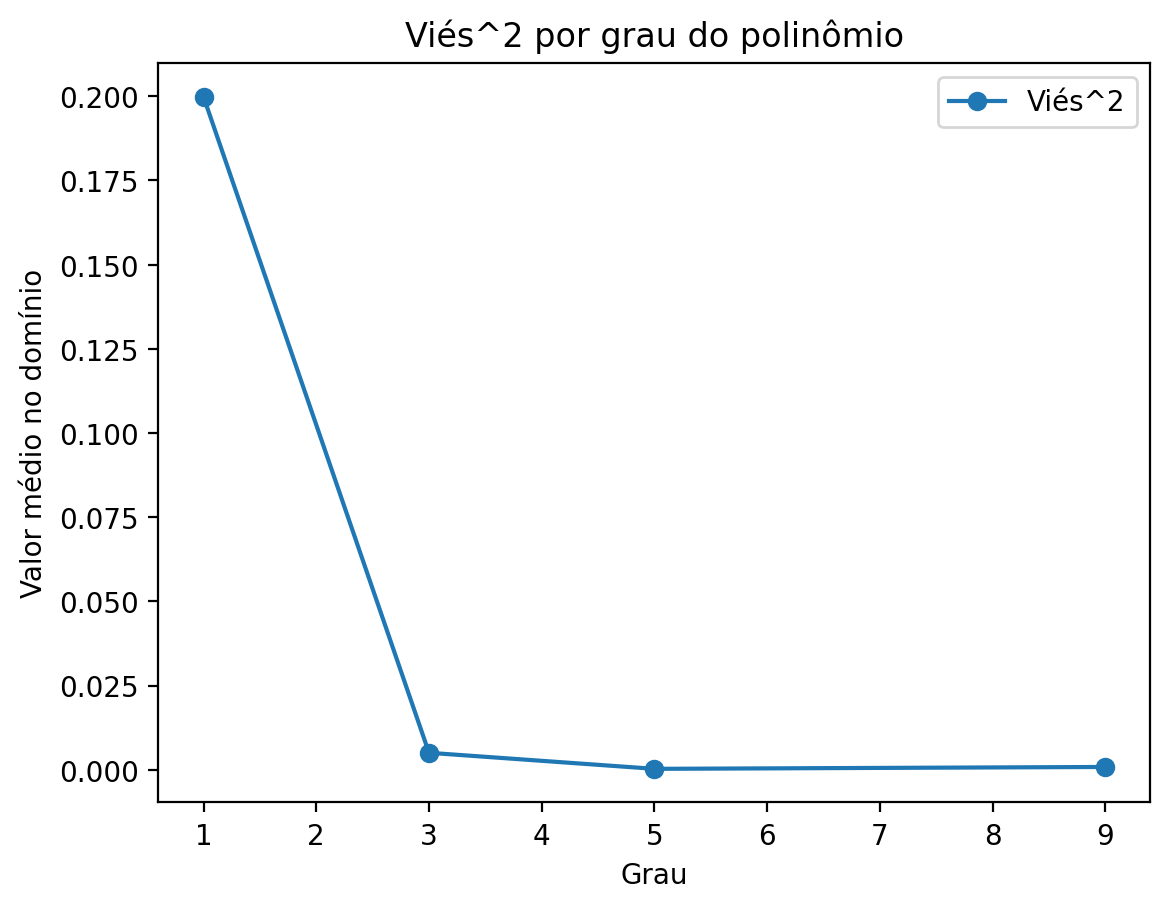

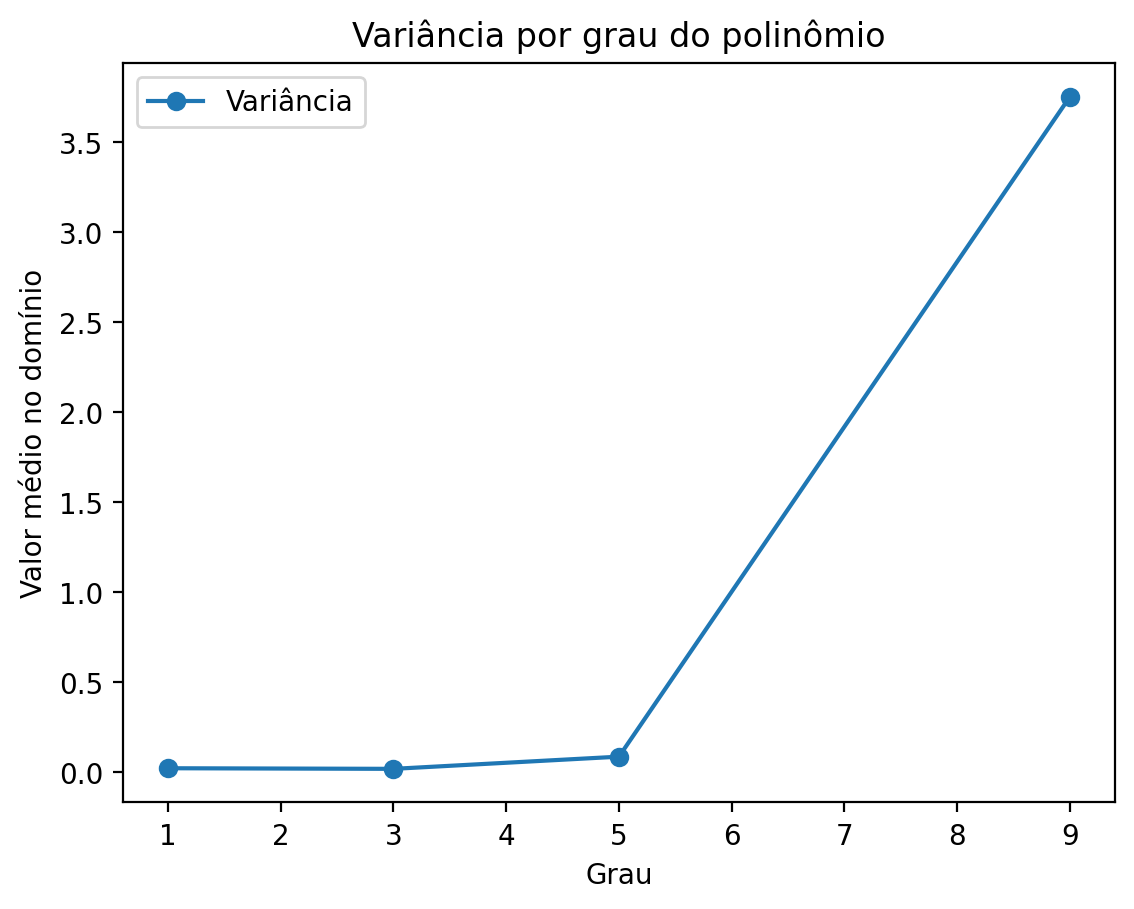

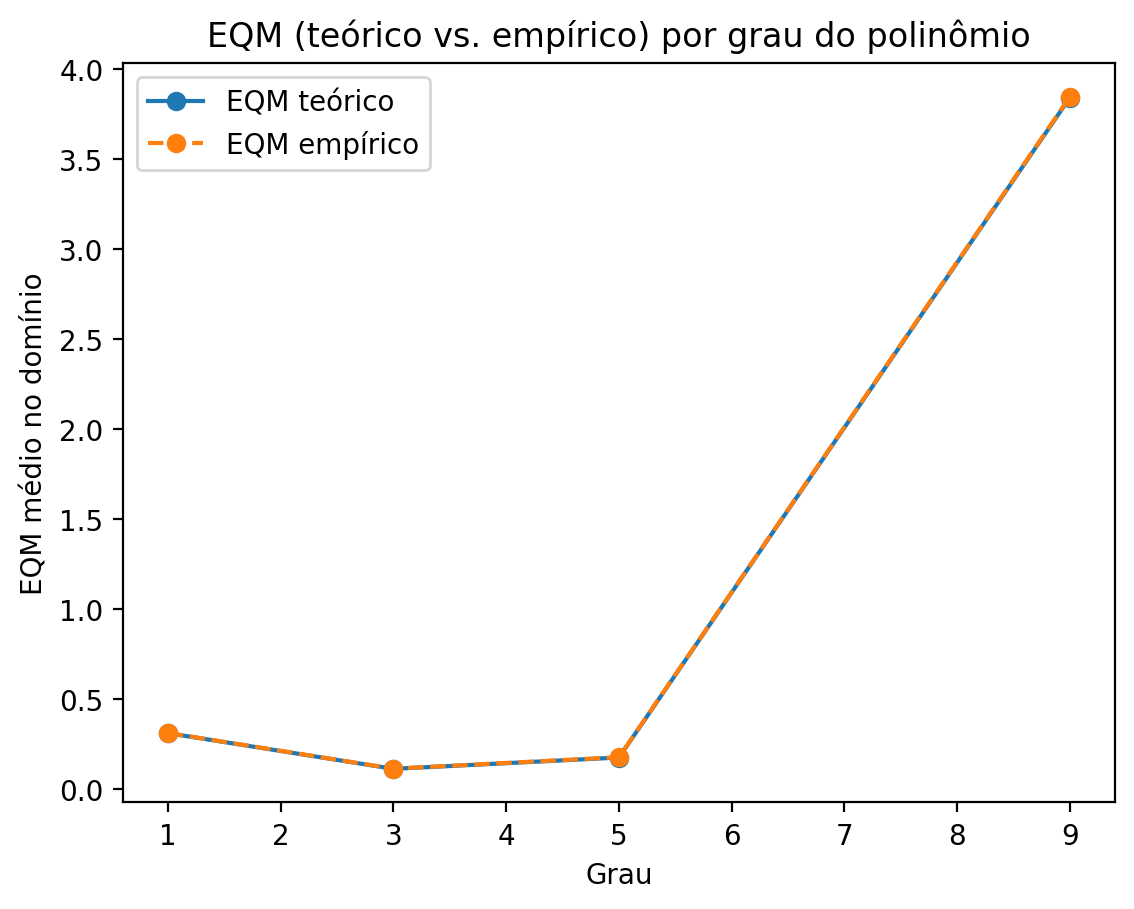

In [20]:

# -------------------------
# Gráficos
# -------------------------
# 1) Função verdadeira e média das predições para cada grau (um gráfico por grau)
for d in degrees:
    mean_pred = all_preds_by_degree[d]["mean_pred"]
    plt.figure()
    plt.plot(X_grid, y_true_grid, label="r(x) verdadeira")
    plt.plot(X_grid, mean_pred, label=f"Média das predições (grau {d})")
    plt.scatter([], [], label=f"n={n_points}, σ={noise_sigma}, ensaios={n_trials}")  # só para legenda
    plt.title(f"Função verdadeira vs. média das predições (grau {d})")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

# 2) Curvas Viés^2, Variância e EQM (teórico e empírico) por grau
x_axis = df["grau"].values

plt.figure()
plt.plot(x_axis, df["Vies2"].values, marker="o", label="Viés^2")
plt.title("Viés^2 por grau do polinômio")
plt.xlabel("Grau")
plt.ylabel("Valor médio no domínio")
plt.legend()
plt.show()

plt.figure()
plt.plot(x_axis, df["Variancia"].values, marker="o", label="Variância")
plt.title("Variância por grau do polinômio")
plt.xlabel("Grau")
plt.ylabel("Valor médio no domínio")
plt.legend()
plt.show()

plt.figure()
plt.plot(x_axis, df["EQM_teorico = Vies2 + Variancia + Variância do erro"].values, marker="o", label="EQM teórico")
plt.plot(x_axis, df["EQM_empirico (aprox.)"].values, marker="o", linestyle="--", label="EQM empírico")
plt.title("EQM (teórico vs. empírico) por grau do polinômio")
plt.xlabel("Grau")
plt.ylabel("EQM médio no domínio")
plt.legend()
plt.show()



**Observações didáticas**

- Em geral, conforme o grau do polinômio aumenta, a **variância** cresce e o **viés²** diminui.
- O **EQM** resulta do equilíbrio entre esses dois termos mais o **erro irredutível** \(\sigma^2\).
- O **EQM empírico** deve acompanhar o **EQM teórico** \((\text{viés}^2 + \text{variância} + \sigma^2)\).
- Experimente: mude `noise_sigma`, `n_points`, `n_trials` e a função `r(x)`.
